In [1]:
import lightgbm as lgbm
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing, feature_selection, metrics, model_selection

import random
from itertools import product
import pickle

import psutil
import warnings
warnings.filterwarnings('ignore')

idx = pd.IndexSlice


In [2]:
input_directory = Path(r"..\\..\\Data\\Input")

feature_directory = Path(r"..\\..\\Data\\Feature")

model_name = "model_lgbm_01"
model_directory = Path()/model_name
model_directory.mkdir(exist_ok=True)


### Import Data

In [3]:
df_data = pd.read_parquet(input_directory/'train_low_mem.parquet', engine='pyarrow').set_index(['time_id','investment_id'])
df_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3141410 entries, (0, 1) to (1219, 3773)
Columns: 302 entries, row_id to f_299
dtypes: float32(301), object(1)
memory usage: 3.6+ GB


In [4]:
df_data = df_data.drop('row_id', axis=1)
df_data.head()

target       f_0       f_1       f_2       f_3  \
time_id investment_id                                                     
0       1             -0.300875  0.932573  0.113691 -0.402206  0.378386   
        2             -0.231040  0.810802 -0.514115  0.742368 -0.616673   
        6              0.568807  0.393974  0.615937  0.567806 -0.607963   
        7             -1.064780 -2.343535 -0.011870  1.874606 -0.606346   
        8             -0.531940  0.842057 -0.262993  2.330030 -0.583422   

                            f_4       f_5       f_6       f_7       f_8  ...  \
time_id investment_id                                                    ...   
0       1             -0.203938 -0.413469  0.965623  1.230508  0.114809  ...   
        2             -0.194255  1.771210  1.428127  1.134144  0.114809  ...   
        6              0.068883 -1.083155  0.979656 -1.125681  0.114809  ...   
        7             -0.586827 -0.815737  0.778096  0.298990  0.114809  ...   
        8             -0.618392 -0.742814 -0.946789  1.230508  0.114809  ...   

                          f_290     f_291     f_292     f_293     f_294  \
time_id investment_id                                                     
0       1              0.366028 -1.095620  0.200075  0.819155  0.941183   
        2             -0.154193  0.912726 -0.734579  0.819155  0.941183   
        6             -0.138020  0.912726 -0.551904 -1.220772 -1.060166   
        7              0.382201  0.912726 -0.266359 -1.220772  0.941183   
        8             -0.170365  0.912726 -0.741355 -1.220772  0.941183   

                          f_295     f_296     f_297     f_298     f_299  
time_id investment_id                                                    
0       1             -0.086764 -1.087009 -1.044826 -0.287605  0.321566  
        2             -0.387617 -1.087009 -0.929529 -0.974060 -0.343624  
        6             -0.219097 -1.087009 -0.612428 -0.113944  0.243608  
        7             -0.609113  0.104928 -0.783423  1.151730 -0.773309  
        8             -0.588445  0.104928  0.753279  1.345611 -0.737624  

[5 rows x 301 columns]

### Feature Engineering

##### Normalization

In [5]:
df_data_norm = df_data.copy()

normalization_dict = {}
for i in tqdm(range(300)):
    feature = f'f_{i}'

    normalization = preprocessing.QuantileTransformer(
        output_distribution='normal', random_state=0).fit(df_data[feature].values.reshape(-1, 1))
    normalization_dict[feature] = normalization

    df_data_norm[feature] = normalization.transform(
        df_data[feature].values.reshape(-1, 1))


f = open(model_directory/'pickle_normalization_dict', 'wb')
pickle.dump(normalization_dict, f)
f.close()

100%|██████████| 300/300 [02:41<00:00,  1.85it/s]


<AxesSubplot:ylabel='Frequency'>

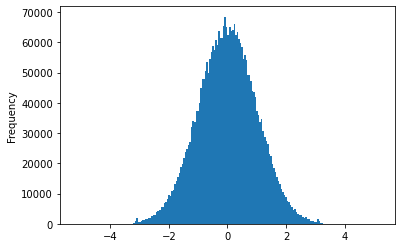

In [6]:
df_data_norm['f_0'].plot(kind='hist', bins=200)


### Feature_selection

In [7]:
df_feature_selection = pd.DataFrame()

for i in tqdm(range(300)):
    feature = f'f_{i}'
    df_feature_selection.loc[feature, 'corr'] = np.corrcoef(
        df_data_norm['target'], df_data_norm[feature])[0][1]


100%|██████████| 300/300 [00:10<00:00, 28.86it/s]


In [8]:
n = len(df_data_norm)
rand_k_index = random.sample(range(n), n//50)
rand_k_index.sort()

mi = feature_selection.mutual_info_regression(
    df_data_norm.iloc[rand_k_index, :].filter(like='f_'), df_data_norm.iloc[rand_k_index, :]['target'])
df_feature_selection['mutual_information'] = mi



In [9]:
selected_feature1 = df_feature_selection[np.abs(
    df_feature_selection['corr']) > 0.03].index
selected_feature2 = df_feature_selection[(
    df_feature_selection['mutual_information']) > 0.03].index
print("seleced feature by corr: ", len(selected_feature1))
print("seleced feature by mutual_information: ", len(selected_feature2))
selected_feature = list(set(selected_feature1).union(set(selected_feature2)))
print("seleced feature in final: ", len(selected_feature))

seleced feature by corr:  62
seleced feature by mutual_information:  30
seleced feature in final:  80


In [10]:
f = open(model_directory/'pickle_selected_feature', 'wb')
pickle.dump(selected_feature, f)
f.close()

### Split Feature & target

In [11]:
feature = df_data_norm[selected_feature]
target = df_data_norm['target']
target

time_id  investment_id
0        1               -0.300875
         2               -0.231040
         6                0.568807
         7               -1.064780
         8               -0.531940
                            ...   
1219     3768             0.033600
         3769            -0.223264
         3770            -0.559415
         3772             0.009599
         3773             1.212112
Name: target, Length: 3141410, dtype: float32

In [12]:
feature

f_193     f_181     f_232      f_28     f_172  \
time_id investment_id                                                     
0       1              0.639075 -0.735823  1.118050  0.085528  0.906622   
        2              0.930463  0.353929  0.227949  0.647818  0.945011   
        6             -0.166376 -0.097530 -0.705530 -0.183767 -0.487557   
        7             -1.120225 -1.528151  0.466435 -1.310882 -1.013628   
        8             -1.262493  0.559995  0.093667 -0.594201 -0.872181   
...                         ...       ...       ...       ...       ...   
1219    3768          -0.370078  0.533908 -0.826903 -0.035808 -0.053930   
        3769          -0.955596  1.084681 -0.839842 -0.748431 -0.326347   
        3770           0.125989  1.242220 -0.343938 -0.504301  0.053997   
        3772          -0.312623 -0.070828  0.776263  1.177674 -0.360411   
        3773           1.475216 -0.222939  0.876177  1.612282  2.087166   

                          f_100     f_159      f_65     f_106     f_207  ...  \
time_id investment_id                                                    ...   
0       1              0.735255  0.652470  0.728373  0.115644  0.005331  ...   
        2             -0.980021  1.246285 -0.100110 -1.113229  0.051849  ...   
        6              1.005527 -0.103272  0.446216  0.160339  0.264848  ...   
        7             -0.980021 -0.352753  0.570173 -1.504939 -1.597029  ...   
        8             -0.980021 -1.362251 -1.395556 -2.394058 -1.307495  ...   
...                         ...       ...       ...       ...       ...  ...   
1219    3768          -0.400635 -0.722744 -1.062437 -0.993829 -0.323678  ...   
        3769          -0.400635 -0.417822 -1.272297  0.735052 -0.512616  ...   
        3770          -0.400635  1.204961  1.168085  0.792703  0.515225  ...   
        3772          -0.400635  1.404446 -0.973981 -1.756942 -0.403521  ...   
        3773           0.690639  0.762170  1.270614  0.442923  0.994351  ...   

                          f_203     f_252      f_41      f_93     f_137  \
time_id investment_id                                                     
0       1              1.092563  1.128910 -0.383024 -0.214948  1.335818   
        2              0.727053  0.106818  0.486480  0.889017 -1.191156   
        6              0.812888  0.202081 -0.383024 -0.775608  0.681474   
        7             -1.498077 -1.096637 -0.383024  0.564596 -1.162210   
        8             -1.797494 -1.445431 -2.047396  0.690958 -0.684999   
...                         ...       ...       ...       ...       ...   
1219    3768          -0.884996 -0.828514 -0.383024  0.252613 -0.458486   
        3769          -1.841771 -1.230674 -0.383024  0.284581 -0.488549   
        3770           0.665096  1.074752  0.528548  0.218223 -0.492252   
        3772          -0.159613  0.544791 -0.383024  0.310166 -0.410889   
        3773           1.563242  1.281767  1.974495 -0.413186  0.360203   

                           f_51     f_158     f_237      f_83     f_127  
time_id investment_id                                                    
0       1              0.245119  0.996062 -0.757689  1.057623 -0.383967  
        2              0.115538  0.968755 -0.584711 -0.570547 -0.891040  
        6             -0.081934  0.273517 -1.040022  0.030549 -0.316686  
        7             -0.371670 -0.758951  0.324927  0.728752 -1.431777  
        8             -0.928432 -1.837306  0.911607  1.195206 -0.136750  
...                         ...       ...       ...       ...       ...  
1219    3768          -0.148439 -0.778214  0.131032  0.324559  0.807970  
        3769          -0.821756 -1.510987  0.874547  1.577192 -0.604208  
        3770           0.886925 -0.188015  0.495764 -1.065873 -1.663583  
        3772           0.811605 -0.279343 -0.093023 -0.390813 -2.423346  
        3773           0.920803  1.295633 -1.128468  0.231411  1.268360  

[3141410 rows x 80 columns]

###  Split Train & Test

In [13]:
train_test_ratio = 5

uniquedate = target.index.get_level_values(level='time_id').unique().tolist()
train_start = 0
train_end = uniquedate[int(
    len(uniquedate)*train_test_ratio/(train_test_ratio+1))]
test_start = uniquedate[int(
    len(uniquedate)*train_test_ratio/(train_test_ratio+1))+1]
test_end = 1219


# dates of train, dates of test
print(
    f'train_start: {train_start}, train_end: {train_end}, test_start: {test_start}, test_end: {test_end}')

feature_train = feature.loc[idx[train_start:train_end, :], :]
feature_test = feature.loc[idx[test_start:test_end, :], :]

target_train = target.loc[idx[train_start:train_end, :]]
target_test = target.loc[idx[test_start:test_end, :]]


train_start: 0, train_end: 1018, test_start: 1019, test_end: 1219


### Train Model

In [14]:
def feval_mse_score(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'mse', round(metrics.mean_squared_error(y_true=labels, y_pred=preds), 5), False


def feval_mape_score(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'mape', round(metrics.mean_absolute_percentage_error(y_true=labels, y_pred=preds), 5), False


def feval_r2_score(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'r2_score', round(metrics.r2_score(y_true=labels, y_pred=preds), 5), True


def corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0][1]


def feval_corr_score(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'corr_score', round(corr(y_true=labels, y_pred=preds), 5), True


class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = min(
                train_end_idx + self.train_length + self.lookahead - 1, len(days) - 1)
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:
            # print(train_start, train_end)
            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates[self.date_idx] <= days[train_end])].index
            test_idx = dates[(dates[self.date_idx] > days[test_start])
                             & (dates[self.date_idx] <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


def get_train_valid_data(X, y, train_idx, valid_idx):
    x_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    x_val, y_val = X.iloc[valid_idx, :], y.iloc[valid_idx]
    # scaler = MinMaxScaler(feature_range=(-1, 1))
    # x_train = scaler.fit_transform(x_train)
    # x_val = scaler.transform(x_val)
    return (x_train, y_train,
            x_val, y_val)


In [15]:
param_names = ['objective', 'num_iterations', 'learning_rate', 'early_stopping_rounds', 'verbose',
               'max_depth', 'num_leaves', 'lambda_l1', 'lambda_l2',
               'feature_fraction',
               'bagging_fraction',
               'extra_trees']

# For Better Accuracy
objective = ['huber']
num_iterations = [2000]
learning_rate = [0.25]
early_stopping_rounds = [25]
verbose = [-1]
# Deal with Over-fitting
max_depth = [-1]
num_leaves = [45]
lambda_l1 = [0]
lambda_l2 = [0]
feature_fraction = [1]
bagging_fraction = [1]
extra_trees = [True]

cv_params = list(product(objective,
                         num_iterations,
                         learning_rate,
                         early_stopping_rounds,
                         verbose,
                         max_depth,
                         num_leaves,
                         lambda_l1,
                         lambda_l2,
                         feature_fraction,
                         bagging_fraction,
                         extra_trees
                         ))

n_splits = 5
train_valid_ratio = 0.2


In [16]:
best_metrics = np.inf
best_models_list = []
best_params = {}

for params_tuple in cv_params:

    params = {param_names[i]: x for (i, x) in enumerate(params_tuple)}
    print('#############################################################################################################################################')
    print('Parmas: ', params, '\n')

    # models_list, metrics_dict = model_train(
    #     model_type, feature_train, target_train, n_splits, train_test_ratio, params)
    date_length = len(feature_train.index.get_level_values(
        level='time_id').unique().tolist())

    train_length = int(date_length/(1+n_splits*train_test_ratio))
    valid_length = int(train_length * train_test_ratio)

    # print(
    #     f'train_date_length: {train_length}, test_date_length: {test_length}')
    # cv = MultipleTimeSeriesCV(n_splits=n_splits,
    #                           lookahead=1,
    #                           test_period_length=valid_length,
    #                           train_period_length=train_length,
    #                           date_idx='time_id'
    #                           )
    cv = model_selection.KFold(
        n_splits=n_splits, random_state=2021, shuffle=True)

    models_list = []
    metrics_dict = pd.DataFrame()

    for i, (train_idx, valid_idx) in enumerate(cv.split(X=feature_train)):
        X_train, y_train, X_valid, y_valid = get_train_valid_data(
            feature_train, target_train, train_idx, valid_idx)

        lgbm_train = lgbm.Dataset(
            X_train, y_train
        )
        lgbm_valid = lgbm.Dataset(
            X_valid, y_valid, reference=lgbm_train
        )

        model = lgbm.train(params=params,
                           train_set=lgbm_train,
                           valid_sets=[lgbm_train, lgbm_valid],
                           #    num_boost_round=1000,
                           feval=[feval_mse_score, feval_corr_score],
                           verbose_eval=100,
                           )

        # y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

        y_train_fit = model.predict(
            X_train, num_iteration=model.best_iteration)
        y_valid_fit = model.predict(
            X_valid, num_iteration=model.best_iteration)

        r2_train = metrics.r2_score(y_train, y_train_fit)
        r2_valid = metrics.r2_score(y_valid, y_valid_fit)
        corr_train = corr(y_train, y_train_fit)
        corr_valid = corr(y_valid, y_valid_fit)
        mse_train = metrics.mean_squared_error(
            y_train, y_train_fit)
        mse_valid = metrics.mean_squared_error(y_valid, y_valid_fit)
        print('---------------------------------------------------------------------------------------------------------------------------------------------')
        print(f'cv: {i+1:01} | mse_train: {mse_train:.5f} | corr_train: {corr_train:0.5f} | mse_valid: {mse_valid:.5f} | corr_valid: {corr_valid:0.5f}')
        print('---------------------------------------------------------------------------------------------------------------------------------------------')
        models_list.append(model)
        metrics_dict.loc[i, 'corr_train'] = corr_train
        metrics_dict.loc[i, 'corr_valid'] = corr_valid
        metrics_dict.loc[i, 'mse_train'] = mse_train
        metrics_dict.loc[i, 'mse_valid'] = mse_valid

    metrics_dict = metrics_dict.mean(axis=0)
    corr_train, corr_valid, mse_train, mse_valid = tuple(
        metrics_dict)
    print(
        f' mean | mse_train: {mse_train:.5f} | corr_train: {corr_train:0.5f} | mse_valid: {mse_valid:.5f} | corr_valid: {corr_valid:0.5f}')
    print()

    if metrics_dict['mse_train'] < best_metrics:
        best_metrics = metrics_dict['mse_train']
        best_models_list = models_list.copy()
        best_params = params


#############################################################################################################################################
Parmas:  {'objective': 'huber', 'num_iterations': 2000, 'learning_rate': 0.25, 'early_stopping_rounds': 25, 'verbose': -1, 'max_depth': -1, 'num_leaves': 45, 'lambda_l1': 0, 'lambda_l2': 0, 'feature_fraction': 1, 'bagging_fraction': 1, 'extra_trees': True} 

Training until validation scores don't improve for 25 rounds
[100]	training's huber: 0.292824	training's mse: 0.83365	training's corr_score: 0.1636	valid_1's huber: 0.295916	valid_1's mse: 0.84464	valid_1's corr_score: 0.14466
[200]	training's huber: 0.290544	training's mse: 0.82652	training's corr_score: 0.1895	valid_1's huber: 0.295002	valid_1's mse: 0.84187	valid_1's corr_score: 0.15526
[300]	training's huber: 0.288676	training's mse: 0.82068	training's corr_score: 0.20935	valid_1's huber: 0.294496	valid_1's mse: 0.84042	valid_1's corr_score: 0.16047
[400]	training's huber: 0.286982	traini

In [17]:
y_test_fit_list = []
for (i, model) in enumerate(best_models_list):
    y_test_fit = model.predict(feature_test)
    y_test_fit_list.append(y_test_fit)

y_test_fit = pd.DataFrame(index=feature_test.index)
y_test_fit['actual'] = target_test
y_test_fit['predict'] = np.mean(y_test_fit_list, axis=0).squeeze()

corr_train = corr(y_test_fit['actual'], y_test_fit['predict'])
corr_test = corr(y_test_fit['actual'], y_test_fit['predict'])
mse_train = metrics.mean_squared_error(y_test_fit['actual'], y_test_fit['predict'])
mse_test = metrics.mean_squared_error(y_test_fit['actual'], y_test_fit['predict'])
print(
    f' test | mse_test: {mse_train:.5f} | corr_test: {corr_train:0.5%}')

 test | mse_test: 0.80947 | corr_test: 12.71994%


In [ ]:
fig = plt.figure(figsize=(20, 20))
for (i, model) in enumerate(best_models_list):
    ax = plt.subplot(1, 5, i+1)
    lgbm.plot_importance(model, max_num_features=100, ax=ax)

In [ ]:
f = open(model_directory/'pickle_best_models_list', 'wb')
pickle.dump(best_models_list, f)
f.close()

In [ ]:
f1 = open(model_directory/'pickle_best_models_list', 'rb')
models_list = pickle.load(f1)